Hamiltoniano:

$$ H = - \sum_{\langle i, j \rangle} J s_i s_j - \sum_{i}(H(t) + h_i)s_i $$

El campo aleatorio se saca de la distribución:

$$ P(h) =  \frac{1}{\sqrt{2 \pi} R} e^{-h^2/2R^2} $$

In [1]:
using PyPlot

INFO: Loading help data...


In [2]:
type MicroEstado
    σ::Array{Int,2}
    h::Array{Float64,2}
    #Vamos a suponer que todas las configuraciones son cuadradas
    L::Int
end

import Base.show 

show(io::IO, m::MicroEstado) = print(io, m.σ)

import PyPlot.imshow

imshow(m::MicroEstado) = imshow(m.σ, interpolation="none")d

imshow (generic function with 2 methods)

In [3]:
function edo_inicial(L::Int)
    σ = -ones(Int, (L,L))
    
    h = Array(Float64, (L,L))
    for i in 1:L^2
        # Temporal, hay que cambiar la distribución
        h[i] = randn()
    end
        
    MicroEstado(σ, h, L)
end

edo_inicial (generic function with 1 method)

In [4]:
function energia_espin(m::MicroEstado, i::Int, j::Int)
    σ = m.σ ; L = m.L
    
    #Tal vez deberíamos de cambiar el signo de la energía
    σ[i,j]*( σ[mod1(i-1, L),j] + σ[mod1(i+1, L),j] + σ[i,mod1(j-1, L)] + σ[i,mod1(j+1, L)] ) + 
    m.h[i,j]
end

energia_espin (generic function with 1 method)

In [5]:
function voltea_espin!(m::MicroEstado, i::Int, j::Int)
    if m.σ[i,j] == -1
        m.σ[i,j] *= -1
    end
end

voltea_espin! (generic function with 1 method)

In [12]:
function max_energia_abajo(m::MicroEstado,min_energia)
    energias = Array(Float64,(m.L,m.L))
    
    for i = 1:m.L, j = 1:m.L
        if m.σ[i,j] == -1
            energias[i,j] = energia_espin(m,i,j)
        else
            energias[i,j] = min_energia
        end
    end
    
    #Si cambiamos signo de la energía sería findmin
    f = findmax(energias) # Da el máximo y el ínidice lineal del máximo
    i = mod1(f[2], m.L)
    j = int(ceil(f[2]/m.L))
    
    f[1], i, j
end

max_energia_abajo (generic function with 1 method)

In [7]:
function espines_vecinos_abajo(m::MicroEstado,i::Int,j::Int)
    vecinos = [ (mod1(i-1,m.L),j), (mod1(i+1,m.L),j), (i,mod1(j-1,m.L)), (i,mod1(j+1,m.L)) ]
    vecinos_abajo = (Int,Int)[]
    
    for k in vecinos
        if m.σ[k...] == -1
            push!(vecinos_abajo, k)
        end
    end
    
    vecinos_abajo        
end

espines_vecinos_abajo (generic function with 1 method)

In [16]:
function avalancha(m::MicroEstado, i::Int, j::Int, H::Float64)    
    voltea_espin!(m,i,j)
    #puede haber un problema, si se escoje de entrada un espín que ya está volteado
    espines_volteados = [(i,j)]
    
    candidatos = espines_vecinos_abajo(m,i,j)
    
    while length(candidatos) > 0
        nuevos_candidatos = (Int,Int)[]
        
        for k in candidatos
            if -energia_espin(m,k...) > H 
                voltea_espin!(m,k...)
                push!(espines_volteados,k)
                nuevos_candidatos = vcat(nuevos_candidatos, espines_vecinos_abajo(m,k...))
            end
        end
        
        candidatos = nuevos_candidatos
    end
    
    m, espines_volteados
end

avalancha (generic function with 1 method)

In [17]:
T = edo_inicial(6)
energia_minima = minimum(T.h)-5
max_energia_abajo(T,energia_minima)

(6.545387502175254,1,4)

In [18]:
T.h

6x6 Array{Float64,2}:
  0.49489    0.77453    0.66622    2.54539   -0.85145    1.09481 
  1.39733    0.613384   0.40109   -1.45083    0.602403   0.386827
 -0.203048  -0.481993  -0.596702   0.30917    0.135438  -2.18222 
 -0.180339  -1.71706    0.342902  -1.5243    -0.672523   0.204564
  0.185429   0.652447  -1.51298    0.299098  -0.719549  -1.07043 
  1.31581    0.671998  -0.529985  -0.947521  -0.545984   0.613654

In [19]:
while sum(T.σ) < T.L^2
#     figure(figsize=(4,4))
#     imshow(T)
    H,i,j = max_energia_abajo(T,energia_minima)
    @show H-4
    T, volteados = avalancha(T,i,j,H)
    @show volteados
    println(T)
    println()
end

H - 4 => 2.545387502175254
volteados => [(1,4)]
[-1 -1 -1 1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]

H - 4 => 1.3973322492075368
volteados => [(2,1)]
[-1 -1 -1 1 -1 -1
 1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]

H - 4 => 1.3158083025587182
volteados => [(6,1)]
[-1 -1 -1 1 -1 -1
 1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 1 -1 -1 -1 -1 -1]

H - 4 => 1.0948099119259656
volteados => [(1,6)]
[-1 -1 -1 1 -1 1
 1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 1 -1 -1 -1 -1 -1]

H - 4 => 0.7745299671104195
volteados => [(1,2)]
[-1 1 -1 1 -1 1
 1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 1 -1 -1 -1 -1 -1]

H - 4 => 0.6524468658342322
volteados => [(5,2)]
[-1 1 -1 1 -1 1
 1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1
 -1 1 -1 -1 -1 -1
 1 -1 -1 -1 -1 -1]

H - 4 => 0.6024029850132244
volt

## Vamos a meterlo dentro de una función. Primero la magnetización:

In [39]:
magnetizacion(m::MicroEstado) = sum(m.σ)

function magnetizacion_disminuye_H(m::MicroEstado)
    energia_minima = minimum(m.h)-5
    N = m.L^2
    mag = [magnetizacion(m)]
    hs = [0.]

    while mag[end] < N
        H,i,j = max_energia_abajo(m,energia_minima)
        push!(hs, H)
        m, volteados = avalancha(m,i,j,H)
        ΔM = 2*length(volteados)
        #Ojo: esto sólo sirve porque volteamos espines hacia abajo
        push!(mag, mag[end] + ΔM)
    end
    
    mag, hs
end

magnetizacion_disminuye_H (generic function with 1 method)

In [48]:
L = 50
N = L^2
m = edo_inicial(L)

@time mag, hs = magnetizacion_disminuye_H(m);

elapsed time: 0.57485771 seconds (26508024 bytes allocated, 17.01% gc time)


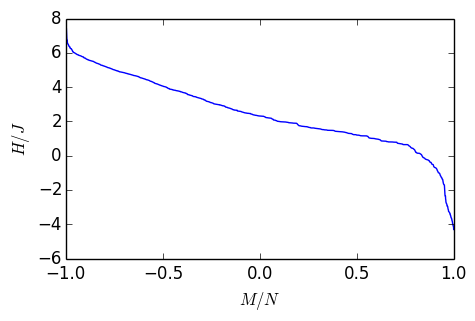

In [50]:
figure(figsize=(5,3))
xlabel(L"M/N")
ylabel(L"H/J") #J=1
plot(mag/N,hs);

## Y la visualización:

In [82]:
function microEstados_disminuye_H(m::MicroEstado, num_pasos::Int)
    energia_minima = minimum(m.h)-5
    edos = Array{Int,2}[copy(m.σ)] #Si no se hace ésto, nada más se copia el apuntador
    sizehint(edos, num_pasos)

    for i in 1:num_pasos-1
        H,i,j = max_energia_abajo(m,energia_minima)
        avalancha(m,i,j,H)
        push!(edos, copy(m.σ))
    end
    
    edos
end

microEstados_disminuye_H (generic function with 1 method)

In [85]:
L = 10
m = edo_inicial(L)
num_pasos = 50

@time edos = microEstados_disminuye_H(m, num_pasos);

elapsed time: 0.001025045 seconds (158392 bytes allocated)


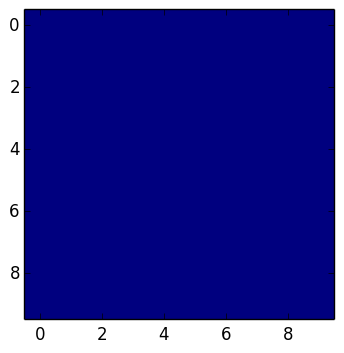

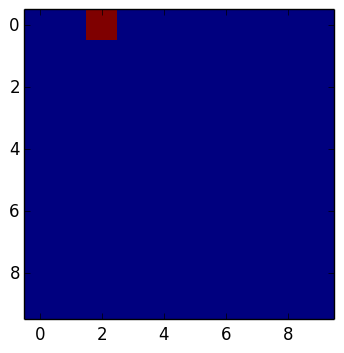

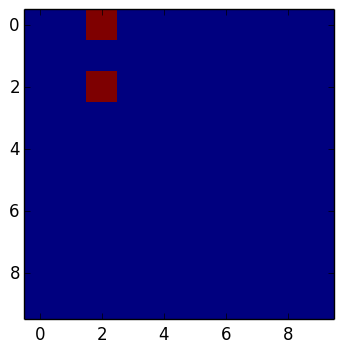

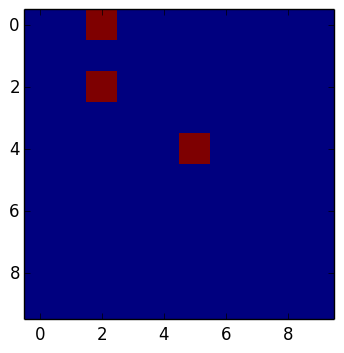

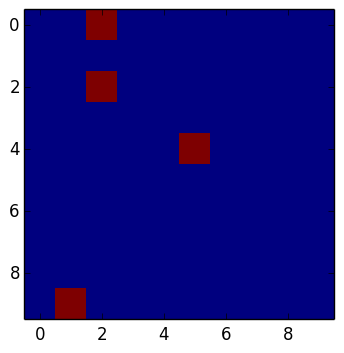

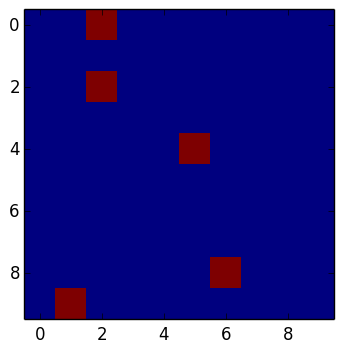

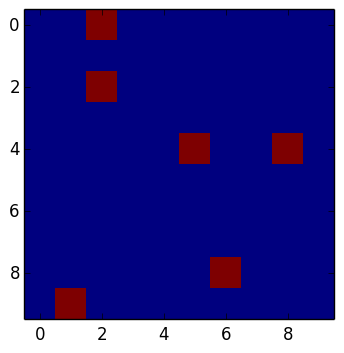

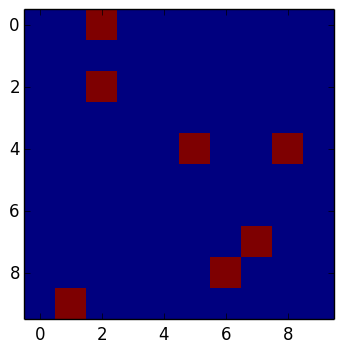

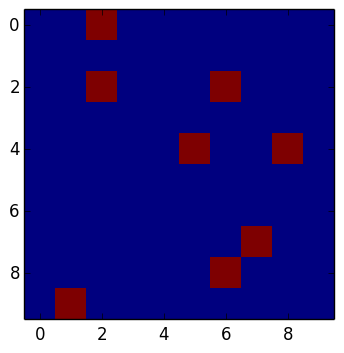

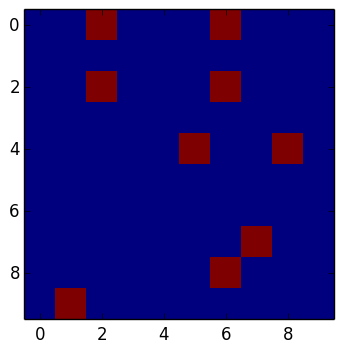

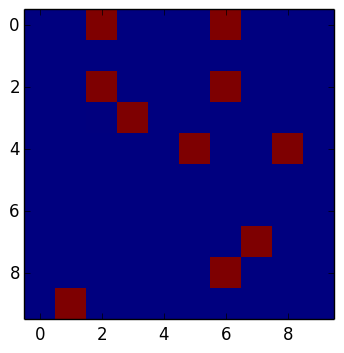

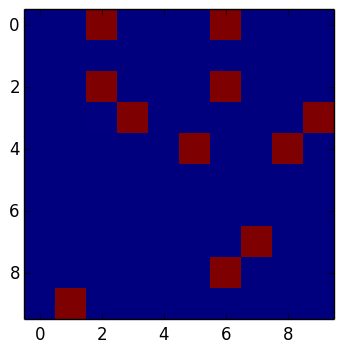

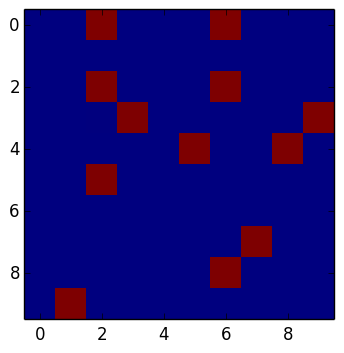

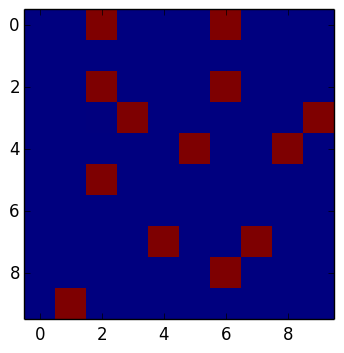

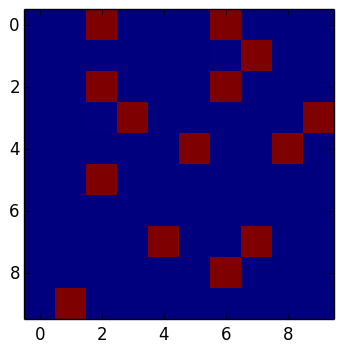

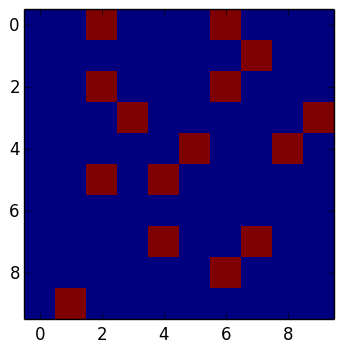

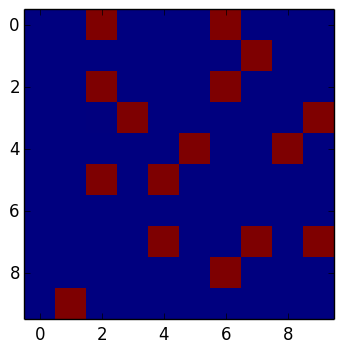

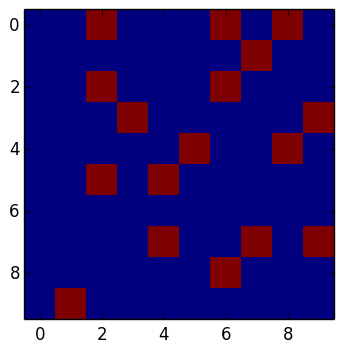

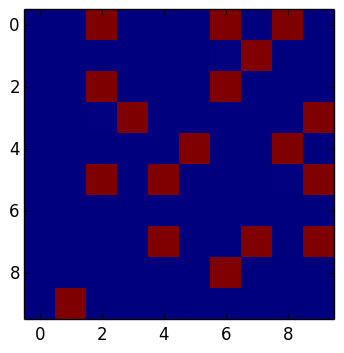

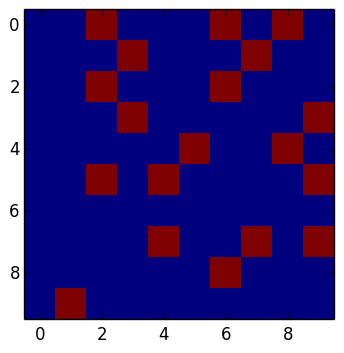

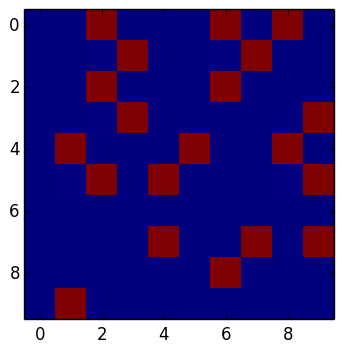

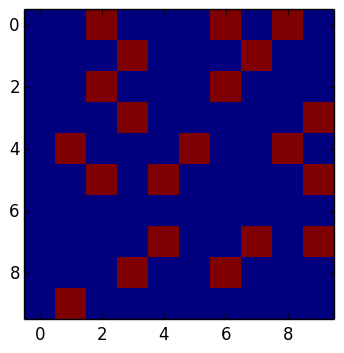

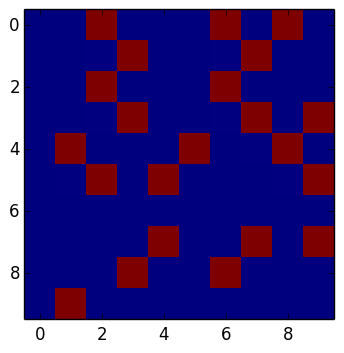

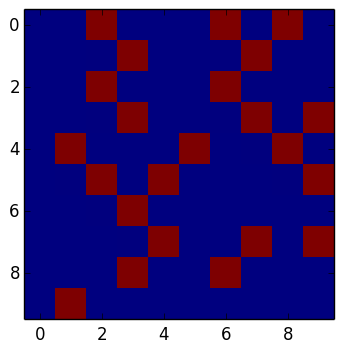

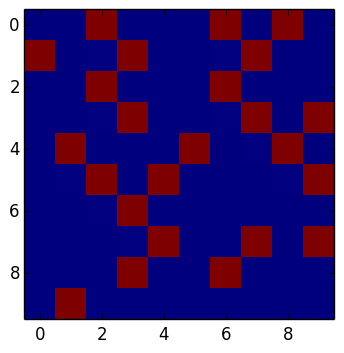

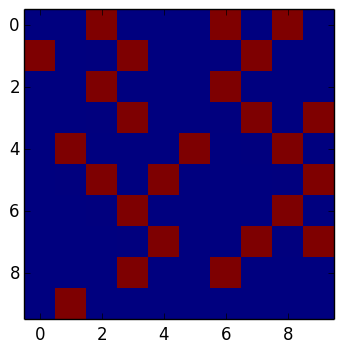

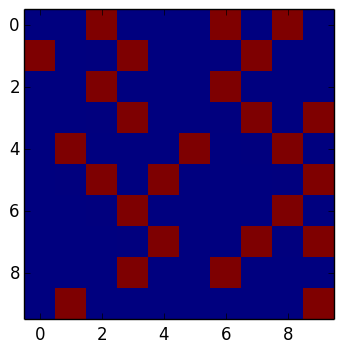

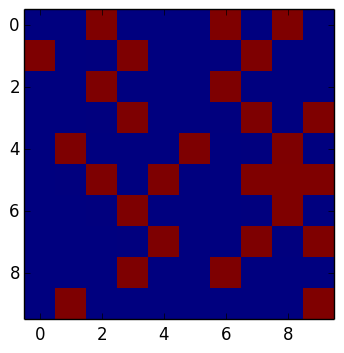

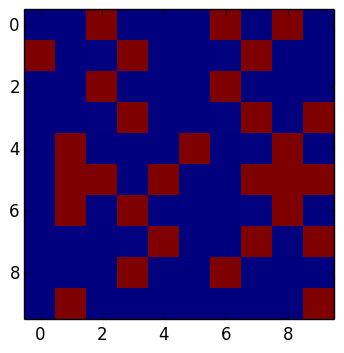

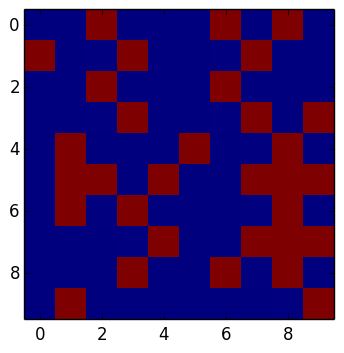

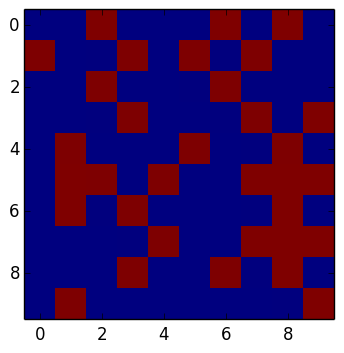

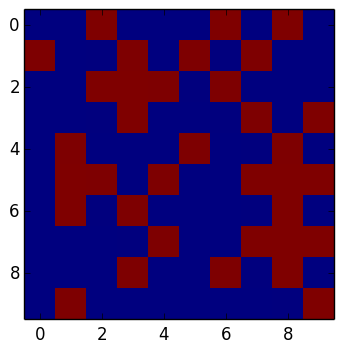

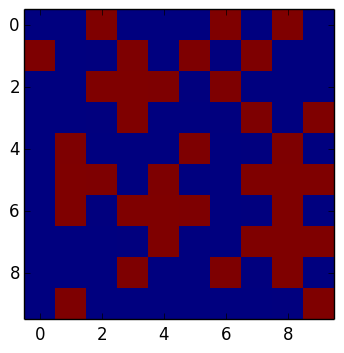

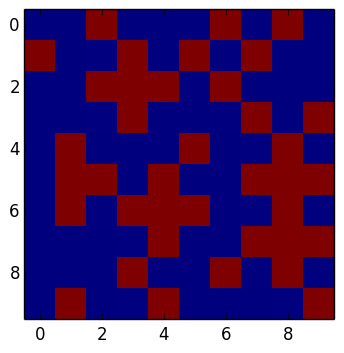

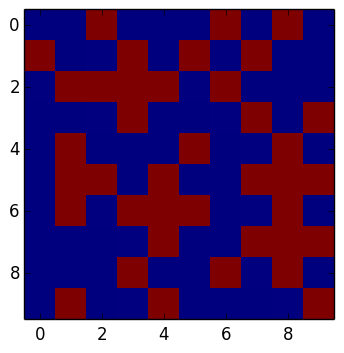

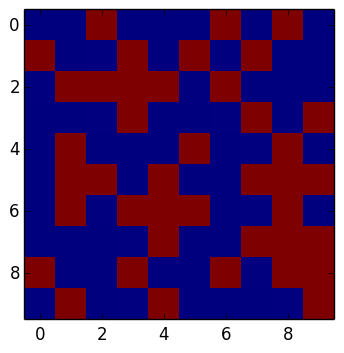

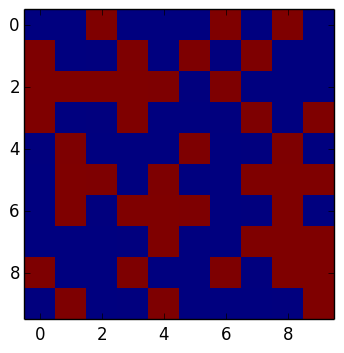

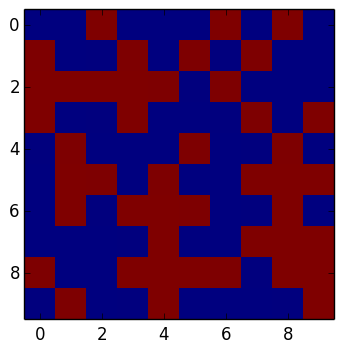

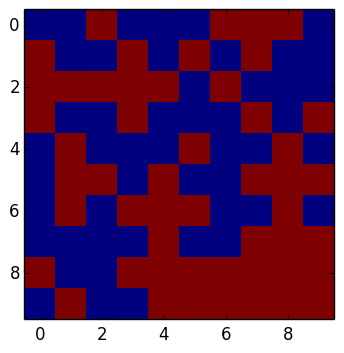

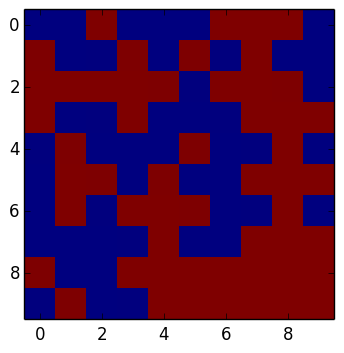

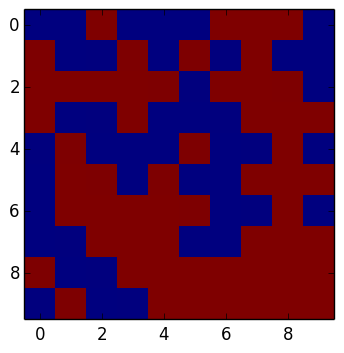

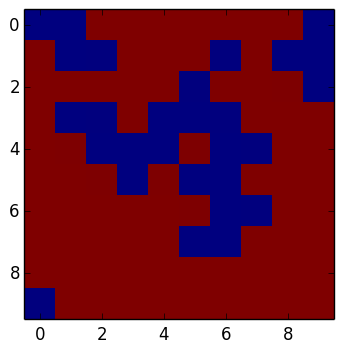

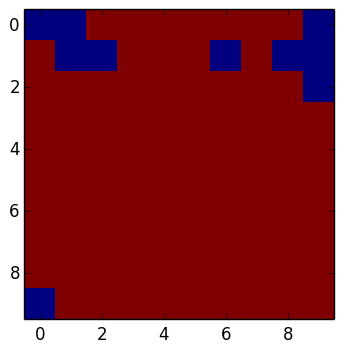

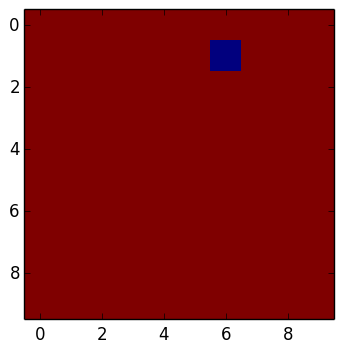

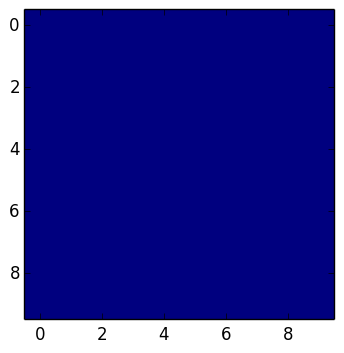

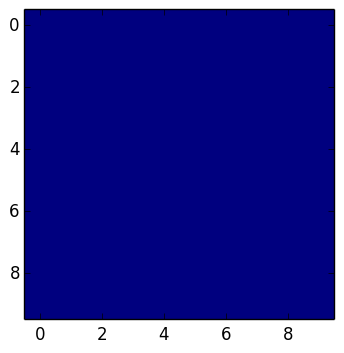

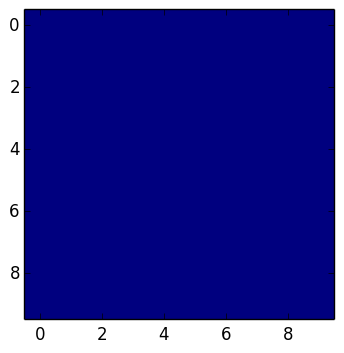

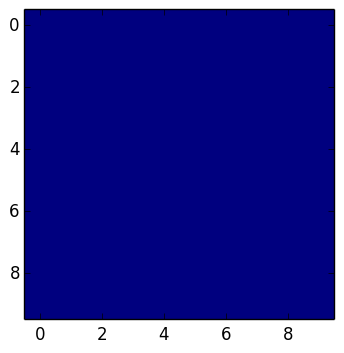

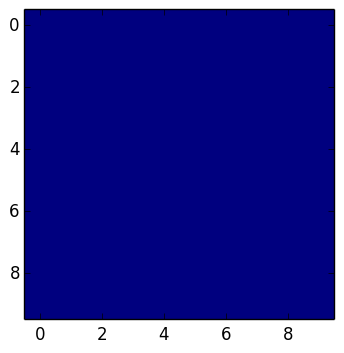

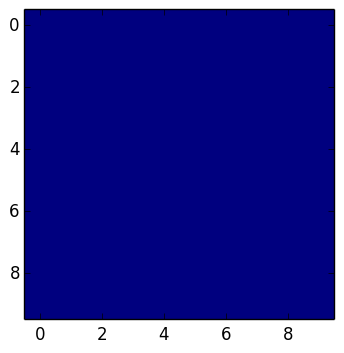

In [87]:
for estado in edos
    figure(figsize=(4,4))
    imshow(estado, interpolation="none")
end